In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias.html

In [2]:
filename = 'covid19-es-and.csv'
fecha = '24/06/2020'
id_noticia = '238624'
url = 'https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias/detalle/' + id_noticia + '.html'

In [3]:
# Load
tables = pd.read_html(url, header=0, thousands='.')
assert len(tables) > 0
dfL = tables[0]

In [4]:
# Prepare
dfL['Fecha'] = fecha
# A partir del 14/05/2020 se cambia el formato del dato añadiendo en la misma columna el número de nuevos casos
for col in ['PCR Positivo',	'Hospitalización', 'UCI', 'Fallecimientos',	'Curados']:
    dfL[col] = dfL[col].str.split(' ').str[0]

dfL

,Provincia,PCR Positivo,Hospitalización,UCI,Fallecimientos,Curados,Fecha
0,Almería,534,246,41,53,740,24/06/2020
1,Cádiz,1.308,593,84,168,1.361,24/06/2020
2,Córdoba,1.352,562,76,115,1.625,24/06/2020
3,Granada,2.498,1.209,136,286,2.948,24/06/2020
4,Huelva,409,223,30,48,479,24/06/2020
5,Jaén,1.478,774,91,188,1.720,24/06/2020
6,Málaga,2.872,1.497,168,287,3.506,24/06/2020
7,Sevilla,2.499,1.213,152,289,2.869,24/06/2020
8,Total,12.950,6.317,778,1.434,15.248,24/06/2020


In [5]:
data = pd.melt(dfL, id_vars=['Provincia', 'Fecha'])
data.sample(5)

,Provincia,Fecha,variable,value
7,Sevilla,24/06/2020,PCR Positivo,2.499
22,Huelva,24/06/2020,UCI,30
10,Cádiz,24/06/2020,Hospitalización,593
32,Jaén,24/06/2020,Fallecimientos,188
21,Granada,24/06/2020,UCI,136


In [6]:
# Save to csv
data.to_csv(filename, encoding='utf-8', header=False, mode='+a', index=False)

In [7]:
# Load full csv
dfL = pd.read_csv(filename, thousands='.', parse_dates=['Fecha'], dayfirst=True)
dfL.tail()

,Provincia,Fecha,variable,value
3235,Huelva,2020-06-24,Curados,479
3236,Jaén,2020-06-24,Curados,1720
3237,Málaga,2020-06-24,Curados,3506
3238,Sevilla,2020-06-24,Curados,2869
3239,Total,2020-06-24,Curados,15248


In [8]:
# Guardar el último día
last_fecha = dfL['Fecha'].max()

In [9]:
# Organizar en forma de tabla
df = pd.pivot_table(dfL, values='value', index=['Provincia', 'Fecha'], columns='variable')
df.sort_index(inplace=True)

In [10]:
# Variaciones con respecto al día anterior
dfV = df.groupby(level='Provincia').pct_change() * 100
dfV.tail()

Curados  Fallecimientos  Hospitalización  PCR Positivo  \
Provincia Fecha                                                                 
Total     2020-06-20  0.345492       -0.209497        -0.031691      0.116351   
          2020-06-21  0.019864        0.000000         0.031701      0.069730   
          2020-06-22  0.046339        0.000000         0.031691      0.069681   
          2020-06-23  0.271290        0.209937         0.000000      0.030948   
          2020-06-24  0.620298        0.139665         0.063361      0.162426   

                           UCI  
Provincia Fecha                 
Total     2020-06-20 -0.128535  
          2020-06-21  0.000000  
          2020-06-22  0.000000  
          2020-06-23  0.000000  
          2020-06-24  0.128700

In [11]:
# Para seleccionar todas las filas de una o varias fechas hay que usar un trick ya que : no se puede usar en este caso
dfG = dfV.loc[(slice(None), [last_fecha]), :]

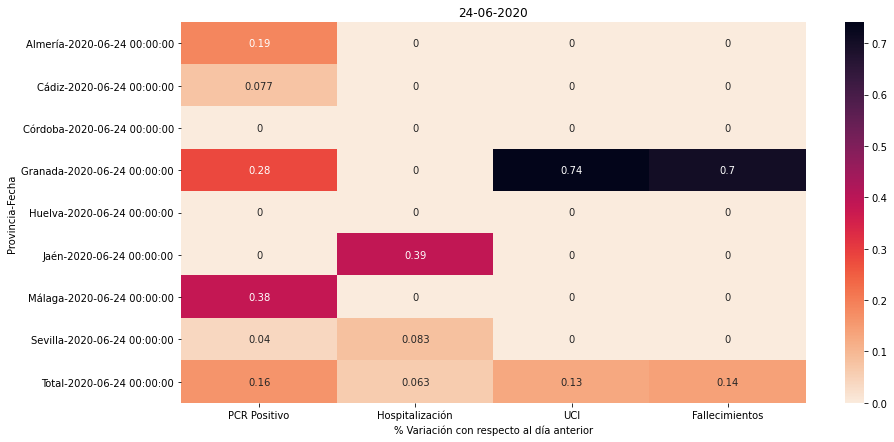

In [12]:
# Set the width and height of the figure
plt.figure(figsize=(14,7))

# Add title
plt.title(last_fecha.strftime('%d-%m-%Y'))

# Invertir los colores
cmap = sns.cm.rocket_r

# Heatmap 
sns.heatmap(data=dfG[['PCR Positivo', 'Hospitalización', 'UCI', 'Fallecimientos']], annot=True, cmap=cmap)

# Add label for horizontal axis
plt.xlabel('% Variación con respecto al día anterior')
plt.show()

In [13]:
provincia = 'Total'
dias = 15
# data = df.loc[provincia][['Hospitalización', 'Curados', 'Fallecimientos']].diff().tail(dias).copy()
data = df.loc[provincia].diff().tail(dias).copy()
titulo = 'Nuevos casos en los últimos ' + str(dias) + ' días en ' + provincia


In [14]:
print(titulo)
print(data)

Nuevos casos en los últimos 15 días en Total
variable    Curados  Fallecimientos  Hospitalización  PCR Positivo  UCI
Fecha                                                                  
2020-06-10    110.0             0.0              2.0          11.0  1.0
2020-06-11     83.0             1.0              5.0          10.0  1.0
2020-06-12     68.0             0.0              2.0           9.0  0.0
2020-06-13    133.0             2.0              2.0           7.0  2.0
2020-06-14      5.0             1.0              1.0           4.0  0.0
2020-06-15     -1.0             0.0              0.0           2.0  0.0
2020-06-16    112.0            -1.0              2.0           4.0  1.0
2020-06-17    128.0             1.0              3.0          10.0  0.0
2020-06-18    128.0             1.0              1.0          15.0  0.0
2020-06-19     73.0            -1.0              2.0          21.0  0.0
2020-06-20     52.0            -3.0             -2.0          15.0 -1.0
2020-06-21      3.0

Nuevos casos en los últimos 15 días en Total. (Nuevos ingresos hospitalarios)


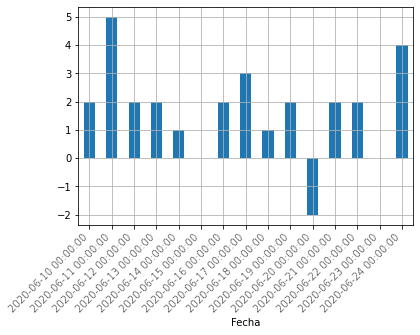

In [15]:
print(titulo + '. (Nuevos ingresos hospitalarios)')
data['Hospitalización'].plot(kind='bar', grid=True)
plt.xticks(
    rotation=45,    
    horizontalalignment='right',
    fontweight='light',
)
plt.show()

In [16]:
# Fecha de último ingreso en hospital
data = df[['Hospitalización']].diff()
data = data[data['Hospitalización'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values('dias', ascending=False)

variable,Fecha,Hospitalización,dias
Provincia,,,
Almería,2020-06-13,1.0,11 days
Málaga,2020-06-20,1.0,4 days
Granada,2020-06-22,1.0,2 days
Córdoba,2020-06-22,1.0,2 days
Huelva,2020-06-23,1.0,1 days
Cádiz,2020-06-23,1.0,1 days
Total,2020-06-24,4.0,0 days
Sevilla,2020-06-24,1.0,0 days
Jaén,2020-06-24,3.0,0 days
